### The Dataset

The data source for this gradient boosting model is Kaggle: https://www.kaggle.com/datasets/pankajjsh06/ibm-watson-marketing-customer-value-data/data

In [1]:
#Importing necessary libraries for loading the data, feature engineering, and visualizations. 
import pandas as pd 
import numpy as np   

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")  

/Users/veeksha_work/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/veeksha_work/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
#reading the csv file
cltv = pd.read_csv('IBM Watson CLTV Data.csv')

#how many rows and columns are in the dataset?
cltv.shape

(9134, 24)

In [3]:
cltv.head(3)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize


### Dataset Cleaning

In [4]:
# Checking for null values
cltv.isnull().sum()

Customer                         0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64

### Feature Engineering

In [5]:
# Changing the target variable name
cltv = cltv.rename(columns={'Customer Lifetime Value': 'CLTV'})

In [6]:
# Engineering number of days policy has been effective feature
# Convert column to datetime
cltv['Effective To Date'] = pd.to_datetime(cltv['Effective To Date'])
# Reference date
ref_date = pd.to_datetime('2011-12-31')
cltv['Effective To Date'] 
# Calculate number of days
cltv['days_effective'] = (ref_date - cltv['Effective To Date']).dt.days

In [7]:
# Dropping irrelevant columns, one-hot encoding categorical variables
cltv = cltv.drop(['Customer', 'Effective To Date'], axis=1) 
# Identify categorical columns (object type)
cat_cols = cltv.select_dtypes(include='object').columns

# One-hot encode only categorical columns
cltv_encoded = pd.get_dummies(cltv, columns=cat_cols, drop_first=True, dtype=int)

In [8]:
# Look at final dataset to be fed into the model
cltv_encoded.head()

,CLTV,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,days_effective,State_California,...,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small
0,2763.519279,56274,69,32,5,0,1,384.811147,310,0,...,0,0,0,0,0,0,0,1,1,0
1,6979.535903,0,94,13,42,0,8,1131.464935,334,0,...,0,0,0,0,0,0,0,0,1,0
2,12887.431650,48767,108,18,38,0,2,566.472247,315,0,...,0,0,0,0,0,0,0,1,1,0
3,7645.861827,0,106,18,65,0,7,529.881344,345,1,...,0,1,0,0,0,1,0,0,1,0
4,2813.692575,43836,73,12,44,0,1,138.130879,331,0,...,0,0,0,0,0,0,0,0,1,0


### Model Building 

In [9]:
from sklearn.model_selection import train_test_split
# Define independent (X) and dependent (y) variables
X = cltv_encoded.drop('CLTV', axis=1)
y = cltv_encoded['CLTV']
X_np = X.values
y_np = y.values

# Split into Training and Testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

#### Manually coded gradient boosted regressor

In [29]:
def sse(y):
    return ((y - y.mean()) ** 2).sum()

def compute_neg_gradient(y_true, y_pred):
    # For least squares loss, residual is negative gradient: y - y_pred
    return y_true - y_pred

'''
BUILDING A DECISION TREE
'''
# build logic that splits a dataset on the feature split with lowest sum of squared errors
def best_sse_split(X_col, y):
    sort_idx = np.argsort(X_col)
    X_sorted = X_col[sort_idx]
    y_sorted = y[sort_idx]
    unique_vals = np.unique(X_sorted)
    if len(unique_vals) == 1:
        return None, None
    thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2
    best_sse = float('inf')
    best_threshold = None
    for threshold in thresholds:
        left_mask = X_sorted <= threshold
        right_mask = ~left_mask
        y_left = y_sorted[left_mask]
        y_right = y_sorted[right_mask]
        if len(y_left) == 0 or len(y_right) == 0:
            continue
        sse_left = sse(y_left)
        sse_right = sse(y_right)
        weighted_sse = sse_left + sse_right
        if weighted_sse < best_sse:
            best_sse = weighted_sse
            best_threshold = threshold
    return best_threshold, best_sse

def fit_tree(X, y, max_depth, min_samples_split):
    # Recursively build a regression tree
    if (max_depth == 0) or (X.shape[0] < min_samples_split) or (np.std(y) == 0):
        return {'leaf': True, 'value': np.mean(y)}
    n_samples, n_features = X.shape
    best_feature, best_threshold, best_sse_val = None, None, float('inf')
    for feature_idx in range(n_features):
        threshold, sse_val = best_sse_split(X[:, feature_idx], y)
        if threshold is not None and sse_val < best_sse_val:
            best_feature, best_threshold, best_sse_val = feature_idx, threshold, sse_val
    if best_feature is None:
        return {'leaf': True, 'value': np.mean(y)}
    left_mask = X[:, best_feature] <= best_threshold
    right_mask = ~left_mask
    left_subtree = fit_tree(X[left_mask], y[left_mask], max_depth - 1, min_samples_split)
    right_subtree = fit_tree(X[right_mask], y[right_mask], max_depth - 1, min_samples_split)
    return {
        'leaf': False,
        'feature': best_feature,
        'threshold': best_threshold,
        'left': left_subtree,
        'right': right_subtree
    }

# Predict class labels for all samples in X using the decision tree.
def predict_tree(tree, X):
    preds = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        node = tree
        while not node['leaf']:
            if x[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        preds[i] = node['value']
    return preds

In [30]:
def build_gradient_boosting(X, y, n_estimators=50, learning_rate=0.1, max_depth=10, min_samples_split=2):
    X = np.asarray(X)
    y = np.asarray(y)
    init_value = np.mean(y)
    y_pred = np.full(len(y), init_value)
    trees = []
    for i in range(n_estimators):
        residual = y - y_pred
        tree = fit_tree(
            X, residual, max_depth=max_depth, min_samples_split=min_samples_split
        )
        update = predict_tree(tree, X)
        y_pred += learning_rate * update
        trees.append(tree)
    # Return model state as a dictionary
    return {
        'init_value': init_value,
        'trees': trees,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split
    }

In [32]:
manual_GBR = build_gradient_boosting(X_train, y_train, n_estimators=50, learning_rate=0.1, max_depth=10, min_samples_split=2)

#### Gradient boosted regressor coded using sklearn

### ✨Bonus - Finding optimal number of trees✨

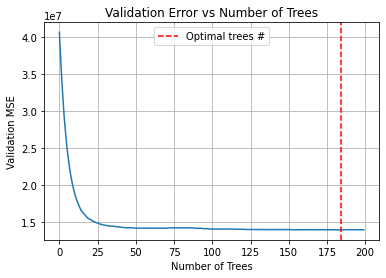

Optimal number of trees: 184


In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# Split  dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

# Train a GBM with more trees than anticipated
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Evaluate staged predictions on the validation set
mse_vals = []
for y_pred in model.staged_predict(X_val):
    mse = mean_squared_error(y_val, y_pred)
    mse_vals.append(mse)
best_n = mse_vals.index(min(mse_vals)) + 1

# Plot validation error vs number of trees
plt.plot(mse_vals)
plt.xlabel('Number of Trees')
plt.ylabel('Validation MSE')
plt.title('Validation Error vs Number of Trees')
plt.axvline(best_n, color='red', linestyle='--', label='Optimal trees #')
plt.legend()
plt.grid(True)
plt.show()

# 5. Get the best number of trees
print(f"Optimal number of trees: {best_n}")


In [16]:
# Initialize GBM Regressor
gbm = GradientBoostingRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=10,
    min_samples_split=2,
    random_state=42
)

# Train model
gbm.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=10, n_estimators=50, random_state=42)

### Predictions

#### Manually coded GBR predictions

In [37]:
# Predict on test set
def predict_gradient_boosting(X, model):
    y_pred = np.full(X.shape[0], model['init_value'])
    for tree in model['trees']:
        y_pred += model['learning_rate'] * predict_tree(tree, X)
    return y_pred

In [38]:
y_pred_manual = predict_gradient_boosting(X_test, manual_GBR)

#### Sklearn coded GBR predictions

In [20]:
# Predict on test set
y_pred = gbm.predict(X_test)

### Model Evaluations

#### Evaluating manually coded GBR predictions

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Calculate Evaluation Metrics:
#Mean absolute error
mae = mean_absolute_error(y_test, y_pred_manual)
#Mean square error
mse = mean_squared_error(y_test, y_pred_manual)
#Root mean square error
rmse = np.sqrt(mse)
#R-square score
r2 = r2_score(y_test, y_pred_manual)

# Print Results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 689.18
Mean Squared Error (MSE): 3963623.45
Root Mean Squared Error (RMSE): 1990.89
R² Score: 0.9231


#### Evaluating manually coded GBR predictions

In [39]:
#Calculate Evaluation Metrics:
#Mean absolute error
mae = mean_absolute_error(y_test, y_pred)
#Mean square error
mse = mean_squared_error(y_test, y_pred)
#Root mean square error
rmse = np.sqrt(mse)
#R-square score
r2 = r2_score(y_test, y_pred)

# Print Results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 694.49
Mean Squared Error (MSE): 4445940.14
Root Mean Squared Error (RMSE): 2108.54
R² Score: 0.9137


In [23]:
# Printing CLV data stats for model eval metric comparison
print(cltv_encoded['CLTV'].max())
print(cltv_encoded['CLTV'].mean())
print(cltv_encoded['CLTV'].min())

83325.38119
8004.940474987081
1898.007675


In [ ]:
# the tree
manual_GBR

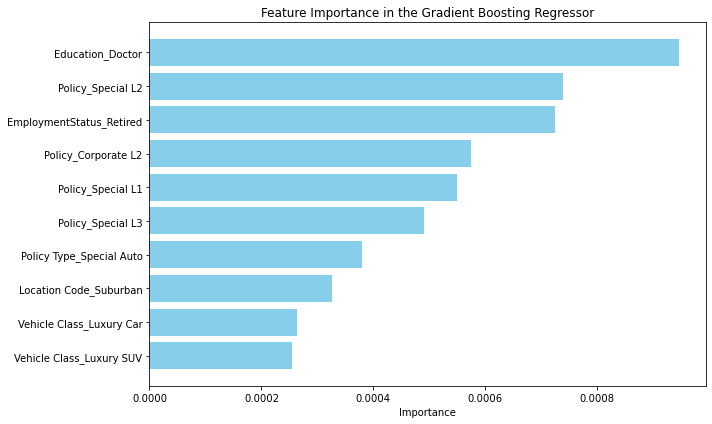

In [40]:
# Visualize importnat features in a model
import matplotlib.pyplot as plt

# Extract feature importances from the trained model
feature_names = X_train.columns.tolist()
importances = gbm.feature_importances_

# Create a DataFrame associating features with their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance descending
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)[0:10]

# Plot horizontal bar chart of feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in the Gradient Boosting Regressor')
plt.tight_layout()
plt.show()
